In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

import functions.eddy_feedback as ef 
import functions.data_wrangling as data 

# Maths Servers:

In [2]:
# import dataset for maths servers
ds = xr.open_mfdataset('/home/links/ct715/data_storage/reanalysis/srip_datasets/JRA55_srip_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = data.seasonal_mean(ds, season='jas')
ds = data.data_checker1000(ds)
ds 

<xarray.Dataset>
Dimensions:  (time: 59, level: 22, lat: 73)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2012 2013 2014 2015 2016
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>
    div1_pr  (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>
    div1_qg  (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>

### Zonal-mean zonal wind (DJF)

In [3]:
# define zonal mean zonal wind
u = ds.ubar

# slice data at 500hPA and set EFP boundaries
u = u.sel( level = 500. )
u = u.where( ds.lat >= -75., drop=True )
u = u.where( ds.lat <= -25., drop=True )

# flip axes so time on x-axis
u = u.transpose()

### DJF Northward EP Flux Divergence

In [4]:
# separate into interannual means
# div1 = ds.div1_pr / 86400 
div1 = ds.div1_pr

# slice data at 500hPA and set EFP boundaries
div1 = div1.sel( level = 500. )
div1 = div1.where( ds.lat >= -75., drop=True )
div1 = div1.where( ds.lat <= -25., drop=True )

# flip axes so time on x-axis
div1 = div1.transpose()

### Covariance

In [5]:
uanom = (u- u.mean('time'))
div1anom = (div1- div1.mean('time') )

prod = uanom*div1anom

### Correlation

In [6]:
ustd = u.std()
div1std = div1.std()

corr = prod / (ustd * div1std)


# Plot all figures

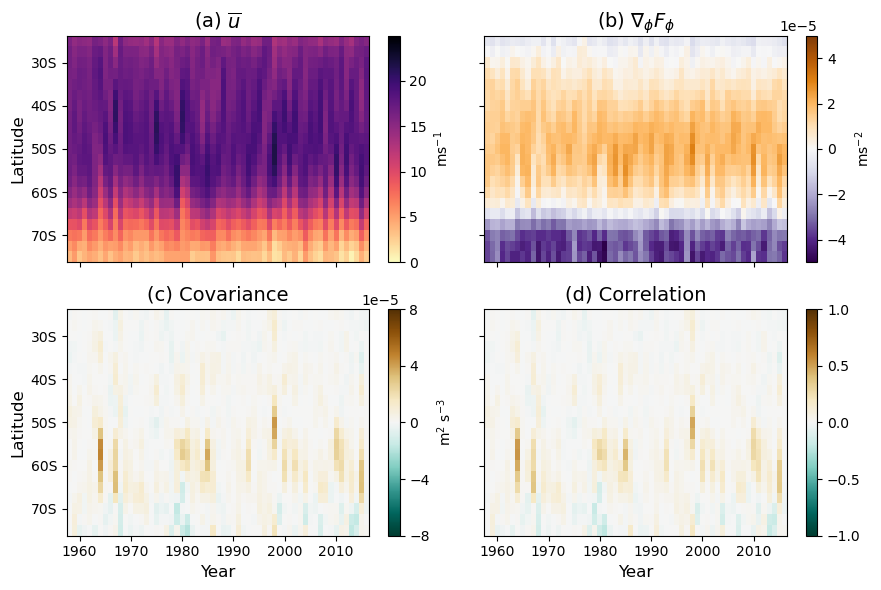

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(9,6))

# plot ubar
u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
axs[0,0].set_yticks(np.arange(-70,-20, 10))
axs[0,0].set_yticklabels(['70S', '60S', '50S', '40S', '30S'])
axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
axs[0,0].set_ylabel('Latitude', fontsize=12)
axs[0,0].set_xlabel('')

# plot div1
div1.plot(ax=axs[0,1], cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

# plot covariance
# Ensure that vmin and vmax are the same as in the first subplot
prod.plot(ax=axs[1,0], cmap='BrBG_r', vmin=-8e-5, vmax=8e-5, 
          cbar_kwargs={'label': 'm$^2$ s$^{-3}$', 'ticks':[-8e-5,-4e-5,0,4e-5,8e-5]})
axs[1,0].set_title('(c) Covariance', fontsize=14)
axs[1,0].set_ylabel('Latitude', fontsize=12)
axs[1,0].set_xlabel('Year', fontsize=12)

# plot correlation
corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
axs[1,1].set_title('(d) Correlation', fontsize=14)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()
